In [86]:
import sys
print(sys.version)  

3.12.11 | packaged by Anaconda, Inc. | (main, Jun  5 2025, 12:58:53) [MSC v.1929 64 bit (AMD64)]


In [87]:
"""
期货回测框架

特点：
1. 完整的保证金、杠杆、强平机制
2. 详细的交易成本计算（手续费、滑点、平今仓）
3. 合约参数配置（乘数、最小跳动单位等）
4. 完整的风险控制（止损、止盈、强平）
5. 全面的绩效统计指标
"""
from future_backtest import *
import panda_data
import pandas as pd
import numpy as np
from dataclasses import dataclass, field
from enum import Enum
from typing import Dict, List, Optional, Tuple, Callable
from abc import ABC, abstractmethod
import warnings
import matplotlib.font_manager
import matplotlib

# 尝试重建字体缓存（某些版本可能不支持，使用try-except包装）
try:
    # 检查并尝试不同的重建方法
    if hasattr(matplotlib.font_manager, '_rebuild'):
        matplotlib.font_manager._rebuild()
    elif hasattr(matplotlib.font_manager.fontManager, '_rebuild'):
        matplotlib.font_manager.fontManager._rebuild()
    # 如果方法不存在，跳过重建（不影响程序运行）
except (AttributeError, Exception) as e:
    # 如果重建失败，不影响程序运行
    pass  # 静默处理，字体设置已在导入时完成

# 读取信号和交易价格数据

In [111]:
# 信号文件路径
df_signals = pd.read_parquet(r'C:\Users\cuiji\Desktop\Hackathon\signal.parquet')
df_signals = df_signals.sort_values('data', ascending=True)
df_signals = df_signals.rename(columns={'data':'date'})

# 生成信号
# df_signals = generate_ma_signals(df_signals, ma_short=7, ma_long=23)

# 实际交易价格表
# df_trades = df_signals[['symbol', 'date', 'close']].copy()

df_trades_all= get_trade_price_data(df_signals)
df_trades = df_trades_all[['symbol', 'date', 'close']].copy()
df_trades = df_trades.sort_values('date', ascending=True)

# 假设模型训练之后的 带信号的表
df_signals = df_signals[['symbol', 'date', 'signal']].copy()

# 使用相反信号
# df_signals['signal'] = df_signals['signal'] *-1

In [112]:
# df_signals.to_excel(r'C:\Users\cuiji\Desktop\Hackathon\back_test\df_parquet1-signal.xlsx', sheet_name='信号表',index=False)

In [113]:
len(df_signals)

4271

In [114]:
# 简单 for 循环：每次信号从 0/无 到 1 或 -1 算一次开仓
# 每次从 1/-1 回到 0 或反向 算一次平仓
# 每完成「开仓 → 平仓」算 count +1

count = 0        # 完整「开仓+平仓」次数
in_position = False   # 是否在持仓中
prev_signal = 0
for signal in df_signals['signal']:
    if signal == 0:  # 过滤 0
            if in_position:
                count += 1        # 遇到 0 → 强制平仓，完成一次
                in_position = False
            prev_signal = 0
            continue
    
    # 信号变化：1 ↔ -1 也算平仓+开仓
    if in_position and signal != prev_signal:
        count += 1            # 先平旧仓
        in_position = True    # 再开新仓
    elif not in_position and signal != 0:
        in_position = True    # 开仓开始

    prev_signal = signal
    
# 最后如果还在持仓，补一次平仓（可选）
if in_position:
    count += 1

print("完整交易次数（开仓+平仓）:", count)

完整交易次数（开仓+平仓）: 884


In [115]:
# df_data_min = panda_data.get_market_min_data(symbol='A2507', start_date='20250101', end_date='20250115',symbol_type="future")
# df_data_min=pd.read_excel(r'C:\Users\cuiji\Desktop\Hackathon\back_test\df_signal_A2507_202501.xlsx')
# df = pd.read_parquet(r'‪C:\Users\cuiji\Desktop\Hackathon\signal.parquet')
# df_data_min=df_data_min.sort_values('date',ascending=True)

# 生成信号
# df_signals = generate_ma_signals(df_data_min, ma_short=7, ma_long=23)


# df_signals.to_excel(r'C:\Users\cuiji\Desktop\Hackathon\back_test\df_signal_A2507_202501-signal.xlsx', sheet_name='信号表',index=False)

# 实际交易价格表
df_trades = df_trades[['symbol', 'date', 'close']].copy()

# 假设模型训练之后的 带信号的表
# df_signals = df_signals[['symbol', 'date', 'signal']].copy() 

# 设置回测参数

In [116]:
# ==================== 回测参数配置 ====================
# 资金与账户参数
initial_capital = 10000000.0  # 初始本金
margin_call_level = 0.0  # 强平线（可用保证金<=此值时强平）

# 交易成本参数（最易被忽略但影响最大）
slippage = 0.1  # 滑点（每手跳数）
commission_per_contract = 0.0  # 固定手续费（按手，如3元/手、5元/手）
close_today_commission_rate = 0.0  # 平今仓手续费率（部分品种更高，如0.0003表示3倍普通手续费）
close_today_commission_per_contract = 0.0  # 平今仓固定手续费（按手）

# 合约与品种参数
max_position = 5000  # 单品种持仓限额（交易所规定）
trade_unit = 1  # 最小交易手数

# 交易规则与执行参数
quantity = 1  # 每次交易手数

# 风控与强平参数
stop_loss_points = None  # 固定止损（点数，如50点），与stop_loss_percent二选一
stop_loss_percent = None  # 百分比止损（2%），与stop_loss_points二选一
take_profit_points = None  # 固定止盈（点数，如100点），与take_profit_percent二选一
take_profit_percent = None # 百分比止盈（4%），与take_profit_percent二选一
trailing_stop_pct = None  # 移动止损百分比（如0.01表示1%）
max_drawdown = None  # 单日最大回撤（5%）

# 回测

In [117]:

# ==================== 创建回测对象 ====================
multi_backtest = MultiSymbolBacktest.check_backtest_data(
    df_signals=df_signals,
    df_trades=df_trades,  # 如果 df_signals 已包含 close，可以传 None
    contract_config_func=None,  # 使用默认配置函数（可根据需要自定义）
    # 资金与账户参数
    initial_capital=initial_capital,
    margin_call_level=margin_call_level,
    # 交易成本参数
    slippage=slippage,
    commission_per_contract=commission_per_contract,
    close_today_commission_rate=close_today_commission_rate,
    close_today_commission_per_contract=close_today_commission_per_contract,
    # 合约与品种参数
    max_position=max_position,
    trade_unit=trade_unit,
    # 交易规则参数
    quantity=quantity,
    # 风控参数
    stop_loss_points=stop_loss_points,
    stop_loss_percent=stop_loss_percent,
    take_profit_points=take_profit_points,
    take_profit_percent=take_profit_percent,
    trailing_stop_pct=trailing_stop_pct,
    max_drawdown=max_drawdown,
    verbose=True
)

# 运行回测
summary_metrics = multi_backtest.run(verbose=True)

# 获取详细结果
trades_df, equity_df, metrics, symbol_metrics = multi_backtest.get_results()

信号数据预览:

数据形状: (4271, 4)
品种列表: ['LC2601']
多品种期货回测
品种数量: 1
品种列表: LC2601
每个品种初始资金: 10000000.00
总初始资金: 10000000.00
数据范围: 2025-10-20 14:35:00 到 2025-11-14 14:30:00
------------------------------------------------------------

回测品种: LC2601
------------------------------------------------------------
开始回测: 信号策略_LC2601
合约: LC2601
数据范围: 2025-10-20 14:35:00 到 2025-11-14 14:30:00
数据点数: 4271
初始资金: 10000000.00
保证金比例: 12.0%
手续费率: 2.30 万
滑点: 0.1 跳
--------------------------------------------------

回测结果:
--------------------------------------------------
total_pnl: -449160.9602
total_return: -0.0449
annual_return: -0.5029
max_drawdown: 0.0455
calmar_ratio: -11.0447
sharpe_ratio: -1.4252
sortino_ratio: -2.0807
trade_count: 884
winning_trades: 294
losing_trades: 590
win_rate: 0.3326
profit_factor: 0.6397
avg_pnl_per_trade: -320.3310
avg_win: 1710.0209
avg_loss: -1332.0657
total_commission: 332805.6302
final_equity: 9550839.0398
initial_capital: 10000000.0000

汇总回测结果
total_initial_capital: 10000000.000

# 汇总结果导出和可视化 

In [118]:
# ==================== 汇总结果导出和可视化 ====================
# 1. 导出汇总指标为DataFrame（中文列名）
summary_df = export_summary_metrics(metrics, symbol_metrics)
print("\n" + "=" * 60)
print("汇总指标（中文）")
print("=" * 60)
print(summary_df)



汇总指标（中文）
     指标类型         初始资金        最终权益         总盈亏    总收益率    年化收益率   最大回撤  \
0      汇总  10000000.00  9550839.04  -449160.96  -4.49%  -50.29%  4.55%   
1  LC2601  10000000.00  9550839.04  -449160.96  -4.49%  -50.29%  4.55%   

       卡玛比率     夏普比率  交易次数  ...  亏损次数      胜率     盈亏比   平均每笔盈亏       总手续费  \
0  -11.0447  -1.4252   884  ...   590  33.26%  0.6397  -320.33  332805.63   
1  -11.0447  -1.4252   884  ...   590  33.26%  0.6397  -320.33  332805.63   

  品种数量  回测天数    索提诺比率     平均盈利      平均亏损  
0  1.0  24.0      NaN      NaN       NaN  
1  NaN   NaN  -2.0807  1710.02  -1332.07  

[2 rows x 21 columns]


交易收益率图表已保存到: trade_returns.png


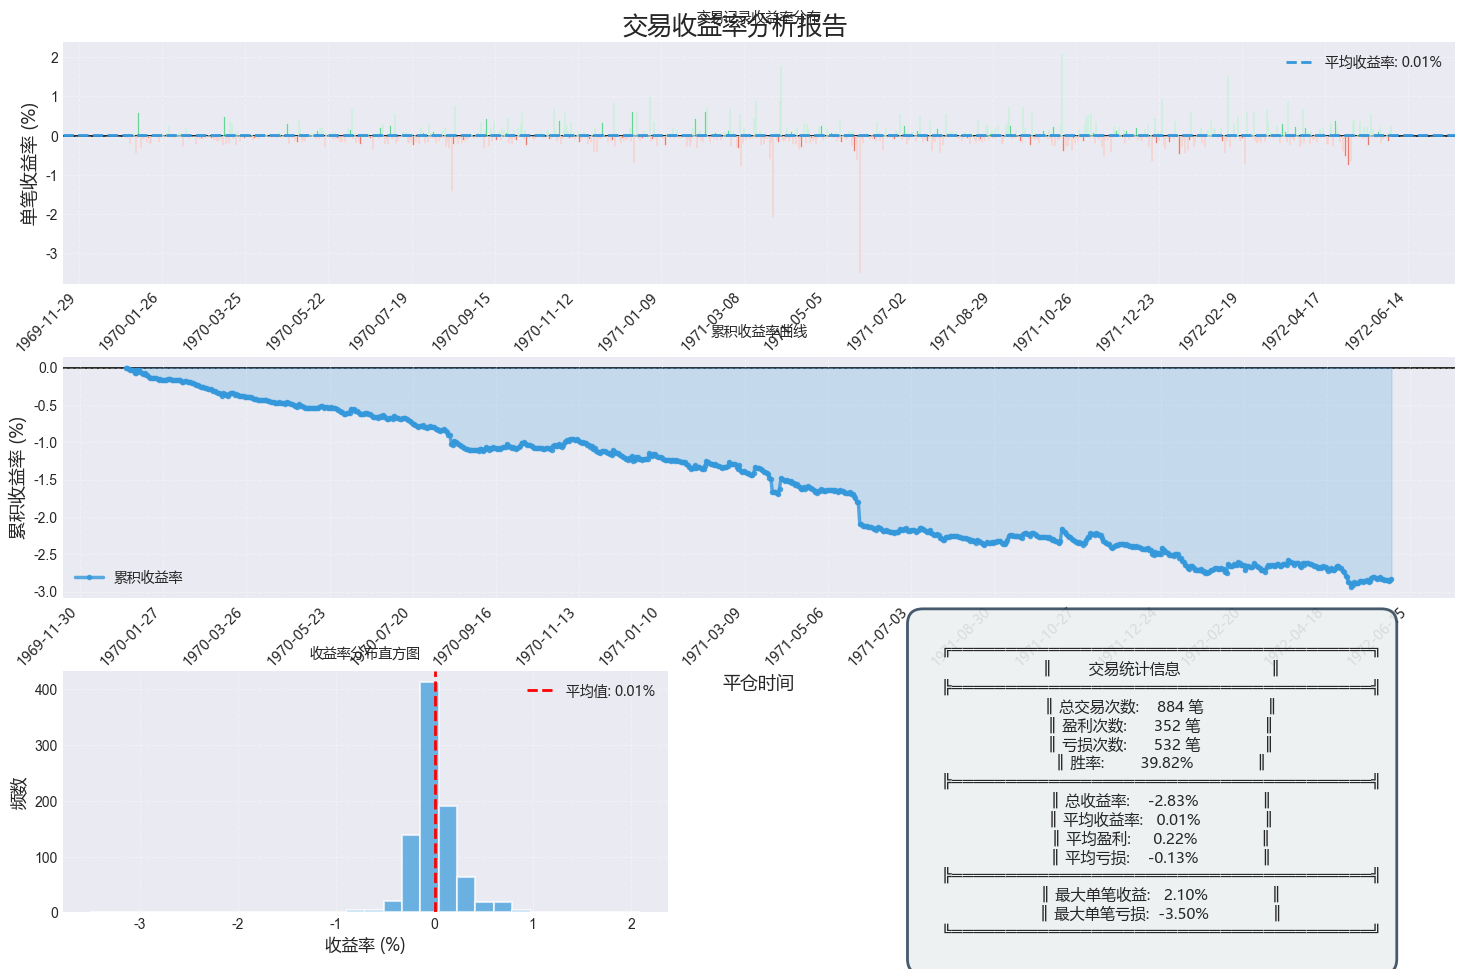

In [119]:

# 2. 可视化交易记录收益率
plot_trade_returns(trades_df, initial_capital=initial_capital, save_path='trade_returns.png')


资金曲线图表已保存到: equity_curve.png


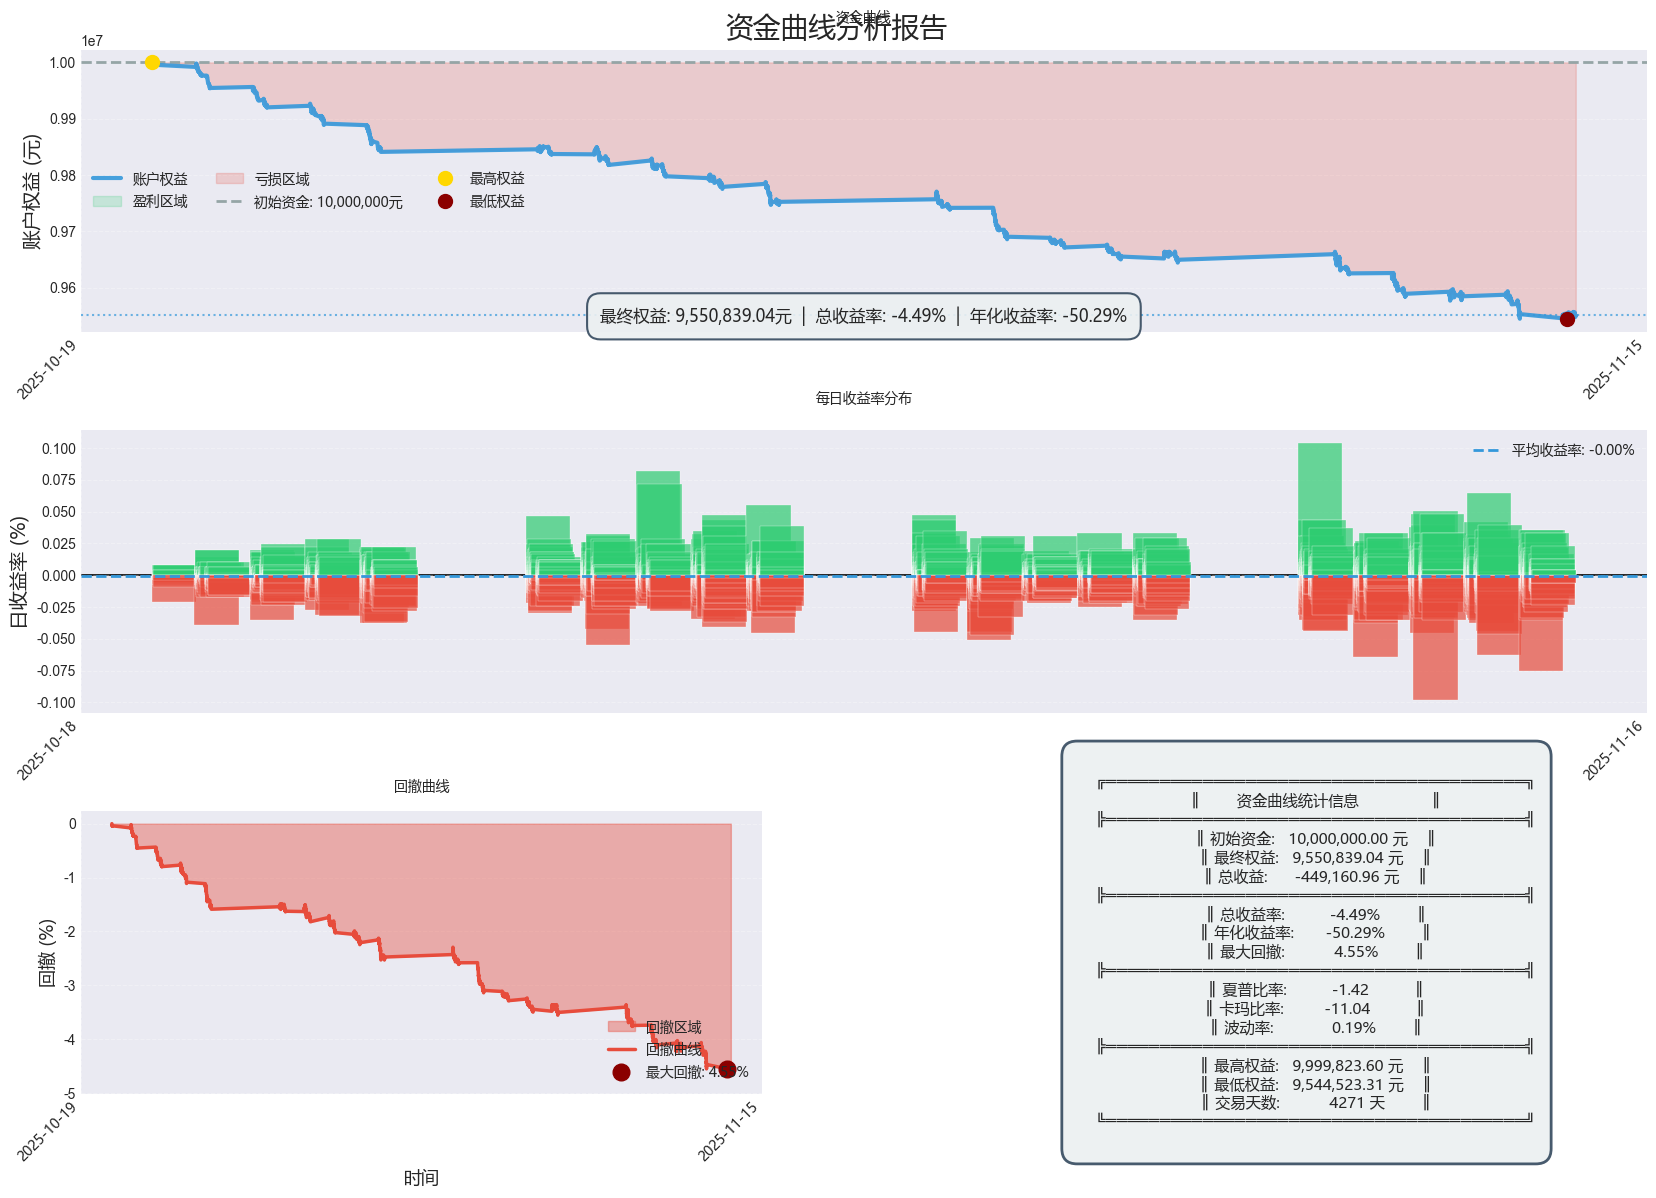

In [120]:

# 3. 可视化资金曲线
plot_equity_curve(equity_df, initial_capital=initial_capital, save_path='equity_curve.png')


In [121]:

# 4. 保存汇总指标到CSV
summary_df.to_csv('backtest_summary.csv', index=False, encoding='utf-8-sig')
print("\n汇总指标已保存到: backtest_summary.csv")

# 5. 导出交易记录
trades_export_df = export_trades(trades_df, file_path='trades_record.csv', format='csv')
print(f"\n交易记录已导出，共 {len(trades_export_df)} 笔交易")
print("\n交易记录预览（前5条）:")
print(trades_export_df.head())

# 打印详细结果
print("\n" + "=" * 60)
print("详细结果")
print("=" * 60)
print("\n交易记录（前10条）:")
print(trades_df.head(10))
print("\n各品种指标:")
for symbol, symbol_metric in symbol_metrics.items():
    print(f"\n{symbol}:")
    print(f"  最终权益: {symbol_metric.get('final_equity', 0):.2f}")
    print(f"  总收益: {symbol_metric.get('total_return', 0)*100:.2f}%")
    print(f"  交易次数: {symbol_metric.get('trade_count', 0)}")
    print(f"  胜率: {symbol_metric.get('win_rate', 0)*100:.2f}%")


汇总指标已保存到: backtest_summary.csv
保存文件时出错: [Errno 13] Permission denied: 'trades_record.csv'
但DataFrame已准备好，可以手动保存

交易记录已导出，共 884 笔交易

交易记录预览（前5条）:
            entry_time            exit_time   side  entry_price  exit_price  \
0  2025-10-20 14:35:00  2025-10-20 14:37:00   LONG      76260.1     76219.9   
1  2025-10-20 14:37:00  2025-10-20 14:39:00  SHORT      76219.9     76160.1   
2  2025-10-20 14:39:00  2025-10-20 14:40:00   LONG      76160.1     75999.9   
3  2025-10-20 14:40:00  2025-10-20 14:41:00  SHORT      75999.9     76020.1   
4  2025-10-20 14:41:00  2025-10-20 14:58:00   LONG      76020.1     76019.9   

   quantity      pnl   pnl_pct  commission exit_reason  symbol  
0         1  -752.70 -0.000527      350.70      signal  LC2601  
1         1   247.53  0.000785      350.47      signal  LC2601  
2         1 -1951.97 -0.002103      349.97      signal  LC2601  
3         1  -551.65 -0.000266      349.65      signal  LC2601  
4         1  -351.69 -0.000003      349.69      signal